\title{myHDL Sawtooth Wave Generator based on the Phase Accumulation method}
\author{Steven K Armour}
\maketitle

This is a simple SawTooth wave generator based on the phase accumulation method inspired by George Pantazopoulos implementation `SawWaveGen` in http://old.myhdl.org/doku.php/projects:dsx1000

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Libraries-used" data-toc-modified-id="Libraries-used-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries used</a></span></li><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Architecture-Setup" data-toc-modified-id="Architecture-Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Architecture Setup</a></span></li><li><span><a href="#Symbolic--Derivation" data-toc-modified-id="Symbolic--Derivation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Symbolic  Derivation</a></span></li><li><span><a href="#myHDL-Implementation" data-toc-modified-id="myHDL-Implementation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>myHDL Implementation</a></span></li><li><span><a href="#myHDL-Testing" data-toc-modified-id="myHDL-Testing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>myHDL Testing</a></span></li><li><span><a href="#myHDL-to-Verilog" data-toc-modified-id="myHDL-to-Verilog-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>myHDL to Verilog</a></span></li></ul></div>

# Libraries used

In [1]:
from myhdl import *
import pandas as pd
from myhdlpeek import Peeker
import  numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sympy import *
init_printing()

# Helper functions

In [2]:
#helper  functions to read in the .v and .vhd generated files into python
def VerilogTextReader(loc, printresult=True):
    with open(f'{loc}.v', 'r') as vText:
        VerilogText=vText.read()
    if printresult:
        print(f'***Verilog modual from {loc}.v***\n\n', VerilogText)
    return VerilogText

def VHDLTextReader(loc, printresult=True):
    with open(f'{loc}.vhd', 'r') as vText:
        VerilogText=vText.read()
    if printresult:
        print(f'***VHDL modual from {loc}.vhd***\n\n', VerilogText)
    return VerilogText

# Architecture Setup

In [ ]:
BitWidth=16
#the max in excluded in intbv 
MaxV=int(2**(BitWidth-1)); MinV=-int(2**(BitWidth-1))
a=intbv(0)[BitWidth:]; a=a.signed()
len(a), a.min, MinV, a.max, MaxV

# Symbolic  Derivation

In [5]:
t, T=symbols('t, T', real=True)
y=Function('y')(t)

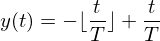

In [6]:
yEq=Eq(y, (t/T)-floor(t/T)); yEq

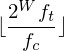

In [7]:
ft, fc, W=symbols('f_t, f_c, W')
PhaseMax=(ft*2**W)//fc; PhaseMax

In [8]:
Targets={ft:440, W:BitWidth}; Targets[fc]=100e3
Targets

In [9]:
PM=PhaseMax.subs(Targets)
f'PhaseMax={PM}'

'PhaseMax=288'

In [10]:
yN=lambdify((t, T), yEq.rhs, dummify=False)
TN=1/100e3; TN
tN=np.linspace(0, .1, PM//4)

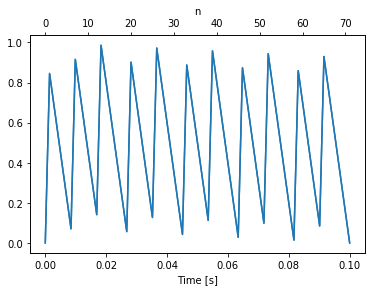

In [11]:
fig, axBot=plt.subplots(ncols=1, nrows=1)
axTop=axBot.twiny()
axBot.plot(tN, yN(tN, TN))
axBot.set_xlabel('Time [s]')
axTop.plot(yN(tN, TN))
axTop.set_xlabel('n');

# myHDL Implementation

In [12]:
@block
def SawToothGen(y, clk, rst, Freq, ClkFreq):
    """
    Inputs:
        clk (bool): system clock 
        rst (bool): reset signal
    
    Ouputs:
        y(2's): SawWave Ouput
    
    Parmeters:
        Freq(float): Target Freq
        ClkFreq(float): System Clock Freq
    """
    
    #Registor to store the phase; aka a counter
    Phase=Signal(intbv(0)[BitWidth:])
    
    # Make phase (Counter) limit
    PhaseCeil=int((Freq*2**BitWidth)//ClkFreq)
    
    @always(clk.posedge)
    def logic():
        if rst:
            Phase.next=0
            y.next=0
        else:
            if Phase==PhaseCeil-1:
                y.next=0
                Phase.next=0
            else:
                y.next=y+1
                Phase.next=Phase+1
        
    return instances()

# myHDL Testing

In [13]:
Peeker.clear()
y=Signal(intbv(0)[BitWidth:]); Peeker(y, 'y')
#Phase=Signal(modbv(0, max=5)); Peeker(Phase, 'P')
clk, rst=[Signal(bool(0)) for _ in range(2)]
Peeker(clk, 'clk'); Peeker(rst, 'rst')

DUT=SawToothGen(y, clk, rst, 440, 100e3)

def SawToothGen_TB():
    
    @always(delay(1))  ## delay in nano seconds
    def clkGen():
        clk.next = not clk
    
    @instance
    def Stimules():
        for i in range(8*PM):
            yield clk.posedge

        for i in range(4):
            if i <2:
                rst.next=True
            else:
                rst.next=False
            yield clk.posedge


        raise StopSimulation
    return instances()

sim=Simulation(DUT, SawToothGen_TB(), *Peeker.instances()).run()
#Peeker.to_wavedrom()        

In [14]:
Simdata=Peeker.to_dataframe()
Simdata=Simdata[Simdata.clk!=0]
Simdata.reset_index(drop=True, inplace=True)
Simdata

,clk,rst,y
0,1,0,1
1,1,0,2
2,1,0,3
3,1,0,4
4,1,0,5
5,1,0,6
6,1,0,7
7,1,0,8
8,1,0,9
9,1,0,10


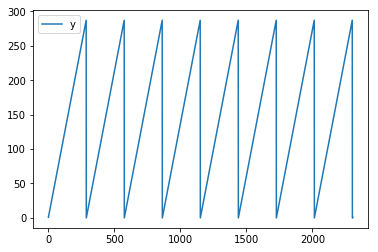

In [15]:
Simdata.plot(y='y')

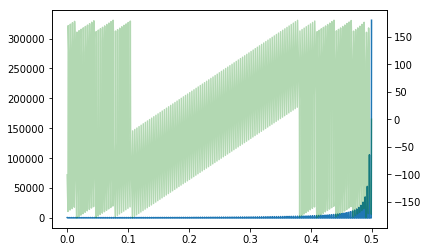

In [16]:
y=Simdata[Simdata.rst!=1]['y']
fy=np.fft.fftshift(np.fft.fft(y, len(y)))
fs=np.fft.fftfreq(len(y))
n=np.where(fs>=0)

plt.plot(fs[n], np.abs(fy[n]))
plt.twinx()
plt.plot(fs[n], np.angle(fy[n], deg=True), color='g', alpha=.3)

In [17]:
f=fs.max()*100e3; f

# myHDL to Verilog

In [18]:
DUT.convert()
VerilogTextReader('SawTooth');

***Verilog modual from SawTooth.v***

 // File: SawTooth.v
// Generated by MyHDL 0.10
// Date: Wed Apr 11 20:11:25 2018


`timescale 1ns/10ps

module SawTooth (
    y,
    clk,
    rst
);


output [15:0] y;
reg [15:0] y;
input clk;
input rst;

reg [15:0] Phase;



always @(posedge clk) begin: SAWTOOTH_LOGIC
    if (rst) begin
        Phase <= 0;
        y <= 0;
    end
    else begin
        if (($signed({1'b0, Phase}) == (288 - 1))) begin
            y <= 0;
            Phase <= 0;
        end
        else begin
            y <= (y + 1);
            Phase <= (Phase + 1);
        end
    end
end

endmodule



/home/iridium/anaconda3/lib/python3.6/site-packages/myhdl/conversion/_toVerilog.py:296: ToVerilogWarning: Output port is read internally: y
  category=ToVerilogWarning
